## Yield curve prediction

The goal of this case study is to use supervised learning-based models to predict the yield
curve. This case study is inspired by the paper “_Artificial Neural Networks in Fixed Income Markets for Yield Curve Forecasting_” by Nunes, Gerding, McGroarty and Niranj

## Content

* [1. Introduction](#0)
* [2. Getting Started - Load Libraries and Dataset](#1)
    * [2.1. Load Libraries](#1.1)    
    * [2.2. Load Dataset](#1.2)
* [3. Exploratory Data Analysis](#2)
    * [3.1 Descriptive Statistics](#2.1)    
    * [3.2. Data Visualisation](#2.2)
* [4. Data Preparation and analysis](#3)
    * [4.1.Feature Selection](#3.1)
* [5.Evaluate Algorithms and Models](#4)        
    * [5.1. Train/Test Split and Evaluation metrics](#4.1)]]
    * [5.3. Compare Models and Algorithms](#4.3)
* [6. Model Tuning and Grid Search](#5)
* [7. Finalize the Model](#6)  
    * [7.1. Results and comparison of Regression and MLP](#6.1)

<a id='0'></a>
# 1. Problem Definition

In the supervised regression framework used for this case study, three tenors (i.e. 1M,
5Y and 30Y) of the yield curve are the predicted variable. These tenors represent short
term, medium term and long-term tenors of the yield curve.

### Features

In order to make predictions, we use the following features: 


    1. Previous Changes in the Treasury Curve at the following tenors: 1 Month, 3 Month, 1 Year, 2 Year, 5 Year, 7 Year, 10 Year, 30 Year
        
    2. Changes in % of Federal Debt held by -
    
        a. Public,       
        b. Foreign Goverments        
        c. Federal Reserve
        
    3. The Coporate Spread on Baa rated Debt Relative to the 10 Year

<a id='1'></a>
# 2. Getting Started- Loading the data and python packages

<a id='1.1'></a>
## 2.1. Loading the python packages

### Feature Variables

In [1]:
# Load libraries
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from matplotlib import pyplot
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

#Libraries for Deep Learning Models
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.layers import LSTM
from keras.wrappers.scikit_learn import KerasRegressor

#Libraries for Statistical Models
import statsmodels.api as sm

#Libraries for Saving the Model
from pickle import dump
from pickle import load

# Time series Models
from statsmodels.tsa.arima_model import ARIMA
#from statsmodels.tsa.statespace.sarimax import SARIMAX

# Error Metrics
from sklearn.metrics import mean_squared_error

# Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression

#Plotting 
from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf

In [2]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

<a id='1.2'></a>
## 2.2. Loading the Data

In [3]:
# Get the data by webscapping using pandas datareader
tsy_tickers = ['DGS1MO', 'DGS3MO', 'DGS1', 'DGS2', 'DGS5', 'DGS7', 'DGS10', 'DGS30',
               'TREAST', # -- U.S. Treasury securities held by the Federal Reserve ( Millions of Dollars )
               'FYGFDPUN', # -- Federal Debt Held by the Public ( Millions of Dollars )
               'FDHBFIN', # -- Federal Debt Held by Foreign and International Investors ( Billions of Dollars )
               'GFDEBTN', # -- Federal Debt: Total Public Debt ( Millions of Dollars )
               'BAA10Y', # -- Baa Corporate Bond Yield Relative to Yield on 10-Year
              ]

from datetime import datetime, timedelta
end_date = datetime.now()
start_date = end_date - timedelta(days=10*365)

tsy_data = web.DataReader(tsy_tickers, 'fred', start=start_date, end=end_date).dropna(how='all').ffill()
tsy_data['FDHBFIN'] = tsy_data['FDHBFIN'] * 1000
tsy_data['GOV_PCT'] = tsy_data['TREAST'] / tsy_data['GFDEBTN']
tsy_data['HOM_PCT'] = tsy_data['FYGFDPUN'] / tsy_data['GFDEBTN']
tsy_data['FOR_PCT'] = tsy_data['FDHBFIN'] / tsy_data['GFDEBTN']

In [4]:
return_period = 5
#Y = tsy_data.loc[:, ['DGS1MO', 'DGS5', 'DGS30']].diff(return_period).shift(-return_period)
#return_period = 5
Y = tsy_data.loc[:, ['DGS1MO', 'DGS5', 'DGS30']].shift(-return_period)
Y.columns = [col+'_pred' for col in Y.columns]

#X = tsy_data.loc[:, ['DGS1MO', 'DGS3MO', 'DGS1', 'DGS2', 'DGS5', 'DGS7', 'DGS10', 'DGS30', 'GOV_PCT', 'HOM_PCT', 'FOR_PCT', 'BAA10Y']].diff(return_period)
X = tsy_data.loc[:, ['DGS1MO', 'DGS3MO', 'DGS1', 'DGS2', 'DGS5', 'DGS7', 'DGS10', 'DGS30', 'GOV_PCT', 'HOM_PCT', 'FOR_PCT', 'BAA10Y']]

dataset = pd.concat([Y, X], axis=1).dropna().iloc[::return_period, :]
Y = dataset.loc[:, Y.columns]
X = dataset.loc[:, X.columns]

In [5]:
dataset.head()

,DGS1MO_pred,DGS5_pred,DGS30_pred,DGS1MO,DGS3MO,DGS1,DGS2,DGS5,DGS7,DGS10,DGS30,GOV_PCT,HOM_PCT,FOR_PCT,BAA10Y
DATE,,,,,,,,,,,,,,,
2014-01-01,0.00,1.77,3.90,0.01,0.07,0.13,0.38,1.75,2.45,3.04,3.96,0.125490,0.718314,0.337948,2.33
2014-01-08,0.01,1.68,3.81,0.00,0.05,0.13,0.43,1.77,2.44,3.01,3.90,0.125726,0.718314,0.337948,2.31
2014-01-15,0.01,1.62,3.68,0.01,0.04,0.13,0.41,1.68,2.33,2.90,3.81,0.126182,0.718314,0.337948,2.32
2014-01-23,0.04,1.55,3.65,0.01,0.04,0.11,0.39,1.62,2.24,2.79,3.68,0.126777,0.718314,0.337948,2.32
2014-01-30,0.07,1.52,3.67,0.04,0.02,0.10,0.36,1.55,2.19,2.72,3.65,0.127444,0.718314,0.337948,2.36


In [6]:
dataset

,DGS1MO_pred,DGS5_pred,DGS30_pred,DGS1MO,DGS3MO,DGS1,DGS2,DGS5,DGS7,DGS10,DGS30,GOV_PCT,HOM_PCT,FOR_PCT,BAA10Y
DATE,,,,,,,,,,,,,,,
2014-01-01,0.00,1.77,3.90,0.01,0.07,0.13,0.38,1.75,2.45,3.04,3.96,0.125490,0.718314,0.337948,2.33
2014-01-08,0.01,1.68,3.81,0.00,0.05,0.13,0.43,1.77,2.44,3.01,3.90,0.125726,0.718314,0.337948,2.31
2014-01-15,0.01,1.62,3.68,0.01,0.04,0.13,0.41,1.68,2.33,2.90,3.81,0.126182,0.718314,0.337948,2.32
2014-01-23,0.04,1.55,3.65,0.01,0.04,0.11,0.39,1.62,2.24,2.79,3.68,0.126777,0.718314,0.337948,2.32
2014-01-30,0.07,1.52,3.67,0.04,0.02,0.10,0.36,1.55,2.19,2.72,3.65,0.127444,0.718314,0.337948,2.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-30,5.52,4.38,4.36,5.55,5.56,5.39,4.90,4.27,4.22,4.12,4.23,0.154856,0.788131,0.225883,1.82
2023-09-07,5.52,4.42,4.39,5.52,5.53,5.40,4.94,4.38,4.35,4.27,4.36,0.154288,0.788131,0.225883,1.81
2023-09-14,5.52,4.61,4.56,5.52,5.55,5.42,5.00,4.42,4.38,4.29,4.39,0.154102,0.788131,0.225883,1.80


<a id='2'></a>
# 3. Exploratory Data Analysis

<a id='2.1'></a>
## 3.1. Descriptive Statistics

In [7]:
dataset.shape

(493, 15)

In [8]:
pd.set_option('display.precision', 3)
dataset.describe()

,DGS1MO_pred,DGS5_pred,DGS30_pred,DGS1MO,DGS3MO,DGS1,DGS2,DGS5,DGS7,DGS10,DGS30,GOV_PCT,HOM_PCT,FOR_PCT,BAA10Y
count,493.000,493.000,493.000,493.000,493.000,493.000,493.000,493.000,493.000,493.000,493.000,493.000,493.000,493.000,493.000
mean,1.138,1.901,2.776,1.127,1.213,1.404,1.528,1.895,2.111,2.262,2.774,0.139,0.747,0.290,2.310
std,1.485,1.012,0.690,1.472,1.527,1.500,1.325,1.004,0.902,0.824,0.686,0.029,0.028,0.036,0.438
min,0.000,0.190,1.170,0.000,0.000,0.040,0.110,0.190,0.360,0.520,1.170,0.091,0.713,0.226,1.590
25%,0.050,1.280,2.290,0.050,0.060,0.170,0.510,1.280,1.550,1.710,2.290,0.120,0.723,0.261,1.990
50%,0.280,1.700,2.870,0.280,0.450,0.810,1.150,1.700,2.050,2.270,2.870,0.134,0.734,0.295,2.220
75%,1.900,2.550,3.130,1.900,1.950,2.170,2.400,2.540,2.640,2.770,3.130,0.164,0.782,0.324,2.530
max,6.020,4.680,4.890,6.020,5.570,5.460,5.120,4.620,4.630,4.590,4.710,0.191,0.788,0.341,4.040


<a id='2.2'></a>
## 3.2. Data Visualization

<Axes: xlabel='DATE'>

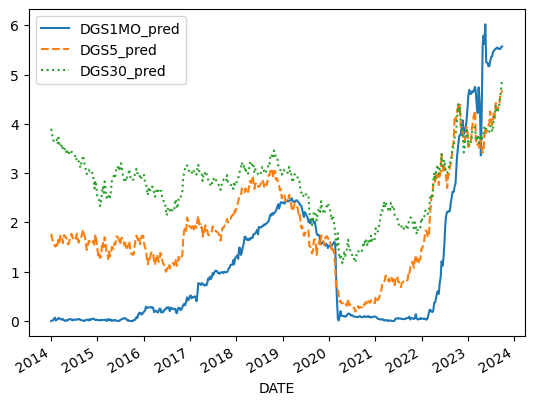

In [9]:
Y.plot(style=['-','--',':'])

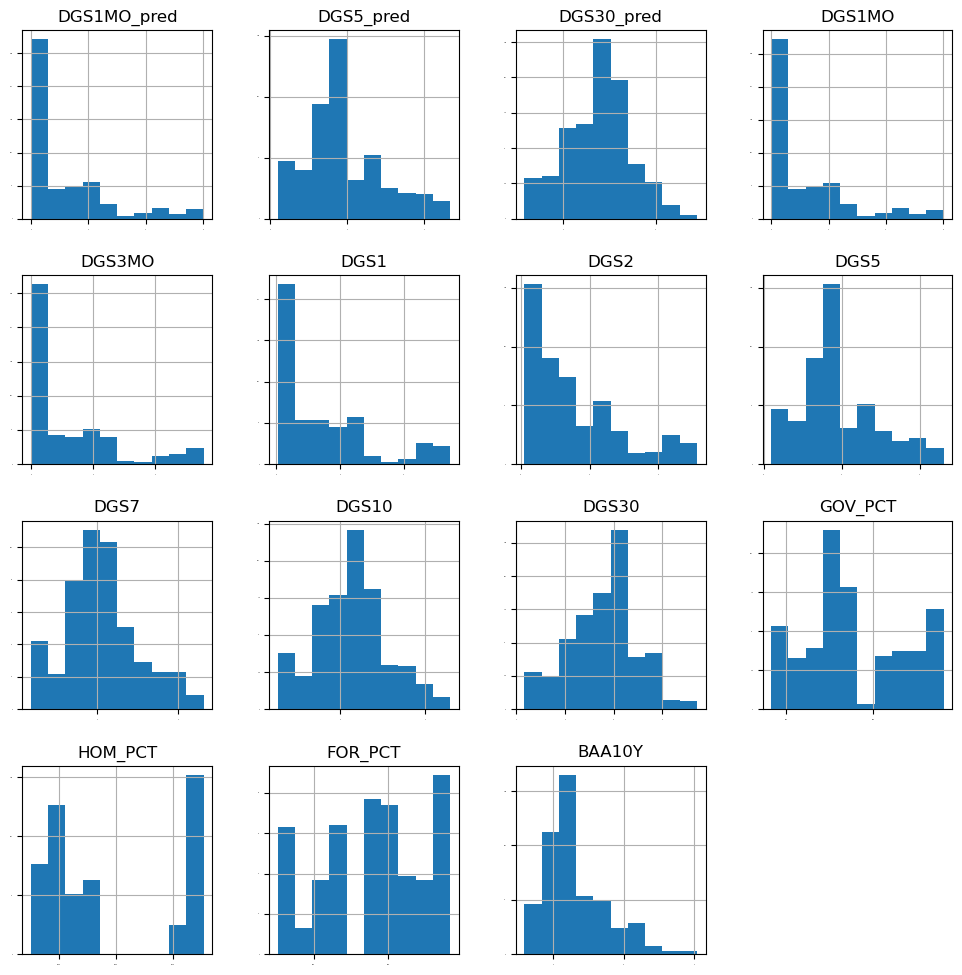

In [10]:
# histograms
dataset.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
pyplot.show()

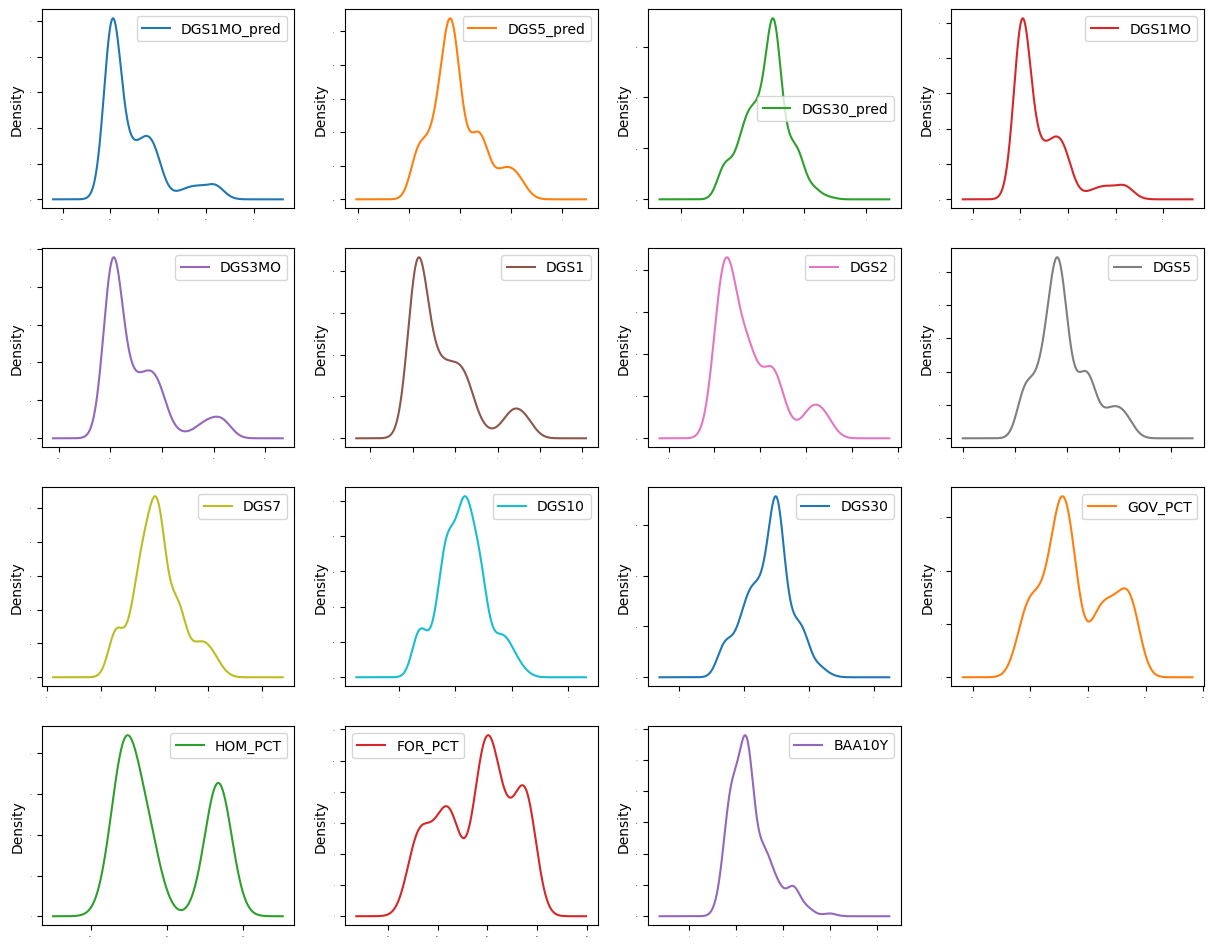

In [11]:
# density
dataset.plot(kind='density', subplots=True, layout=(5,4), sharex=False, legend=True, fontsize=1, figsize=(15,15))
pyplot.show()

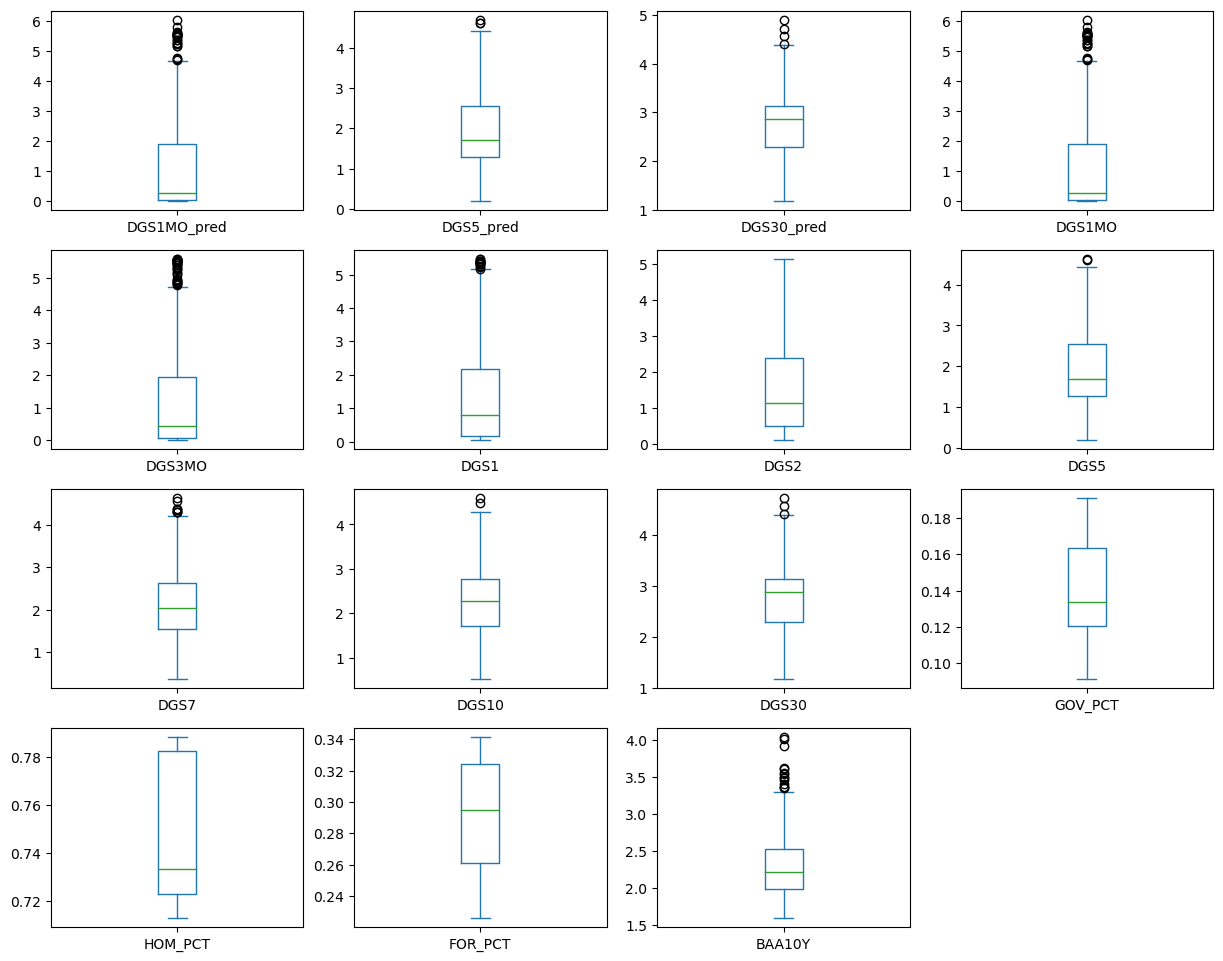

In [12]:
#Box and Whisker Plots
dataset.plot(kind='box', subplots=True, layout=(5,4), sharex=False, sharey=False, figsize=(15,15))
pyplot.show()

Next We look at the interaction between these variables.

<Axes: title={'center': 'Correlation Matrix'}>

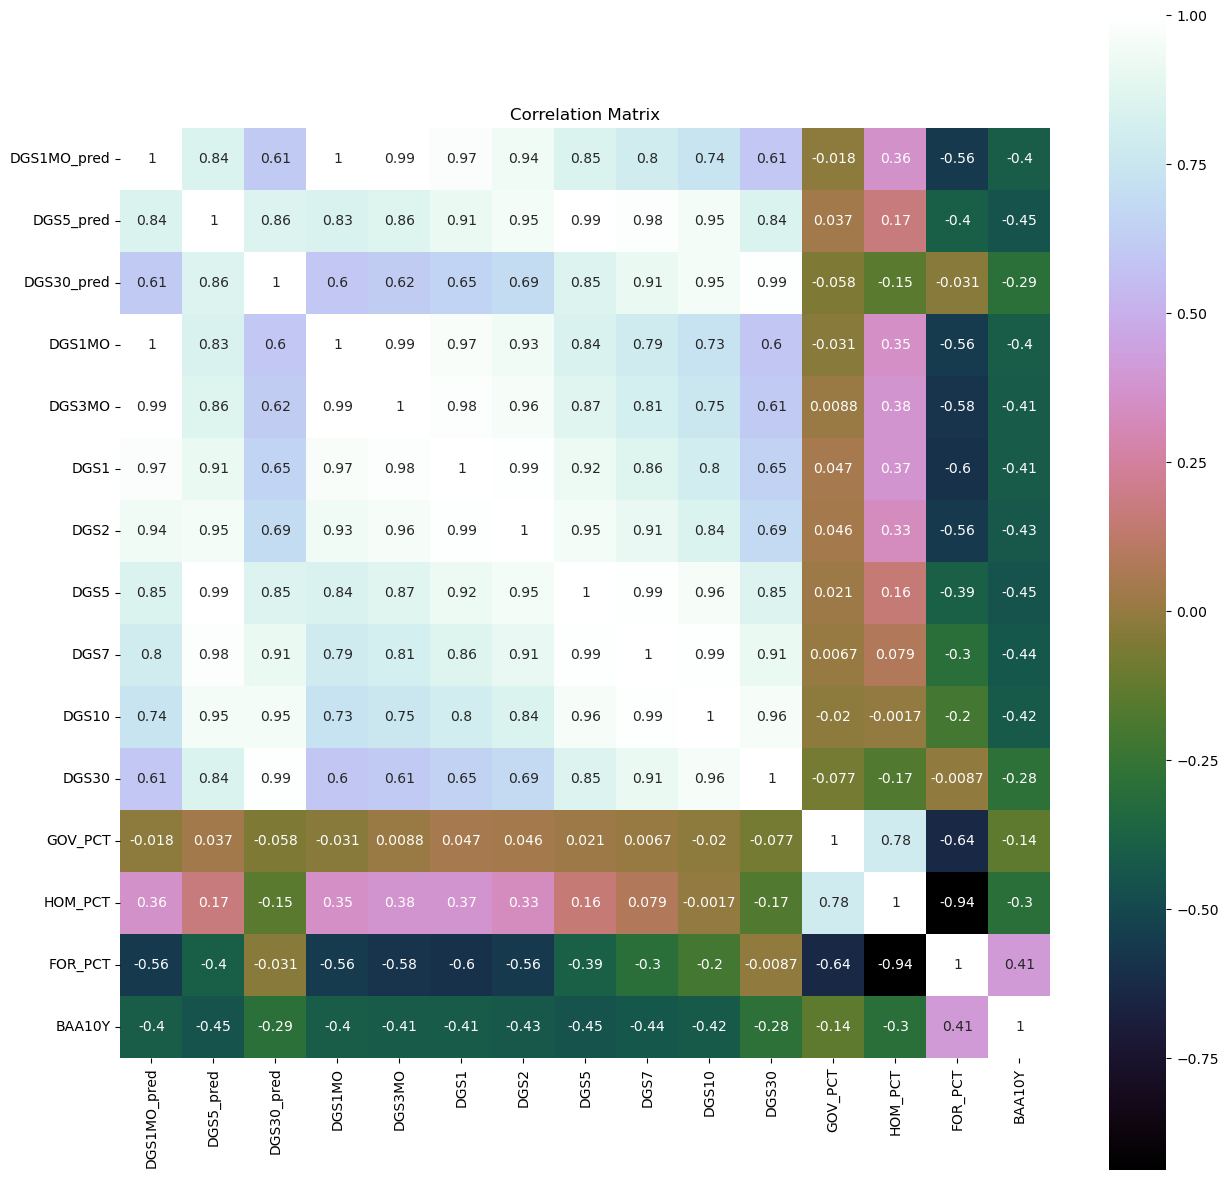

In [13]:
# correlation
correlation = dataset.corr()
pyplot.figure(figsize=(15,15))
pyplot.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

Form the correlation plot, we see that the 1 month and the 30 year yield data points are negatively autocorrelated. The 5 year yield also seems toe be negativly correlated with the changes in foreign goverment purchases.

<Figure size 1500x1500 with 0 Axes>

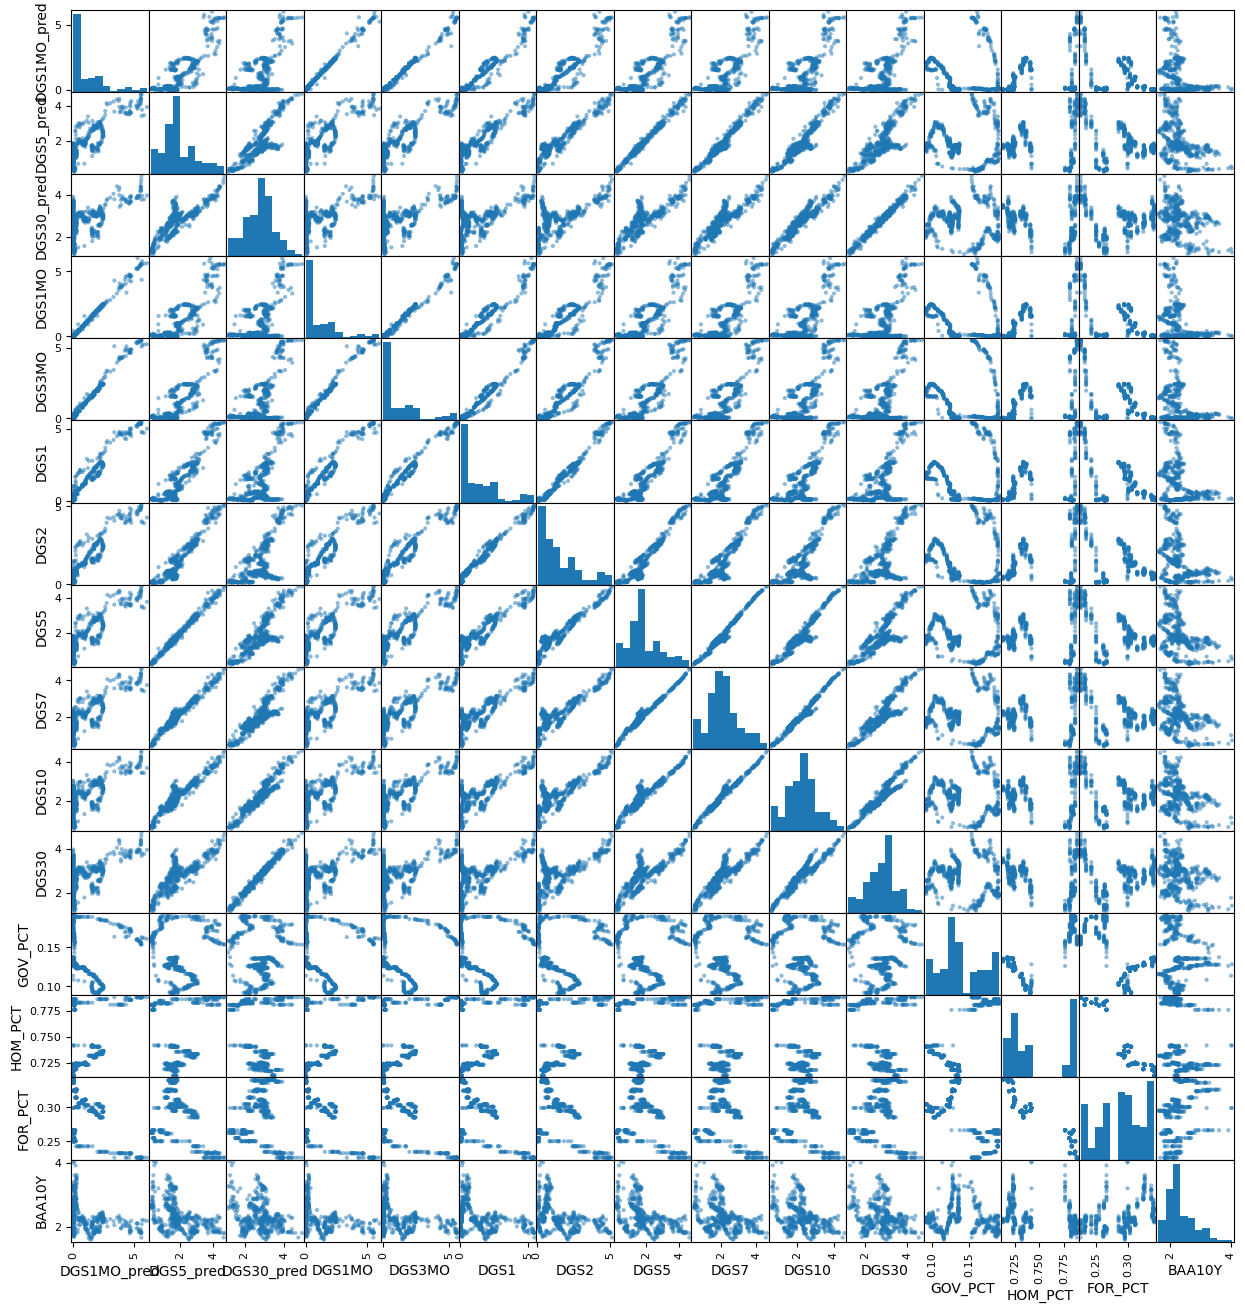

In [14]:
# Scatterplot Matrix
pyplot.figure(figsize=(15,15))
scatter_matrix(dataset,figsize=(15,16))
pyplot.show()

<a id='2.3'></a>
## 3.3. Time Series Analysis

#### 1 Month

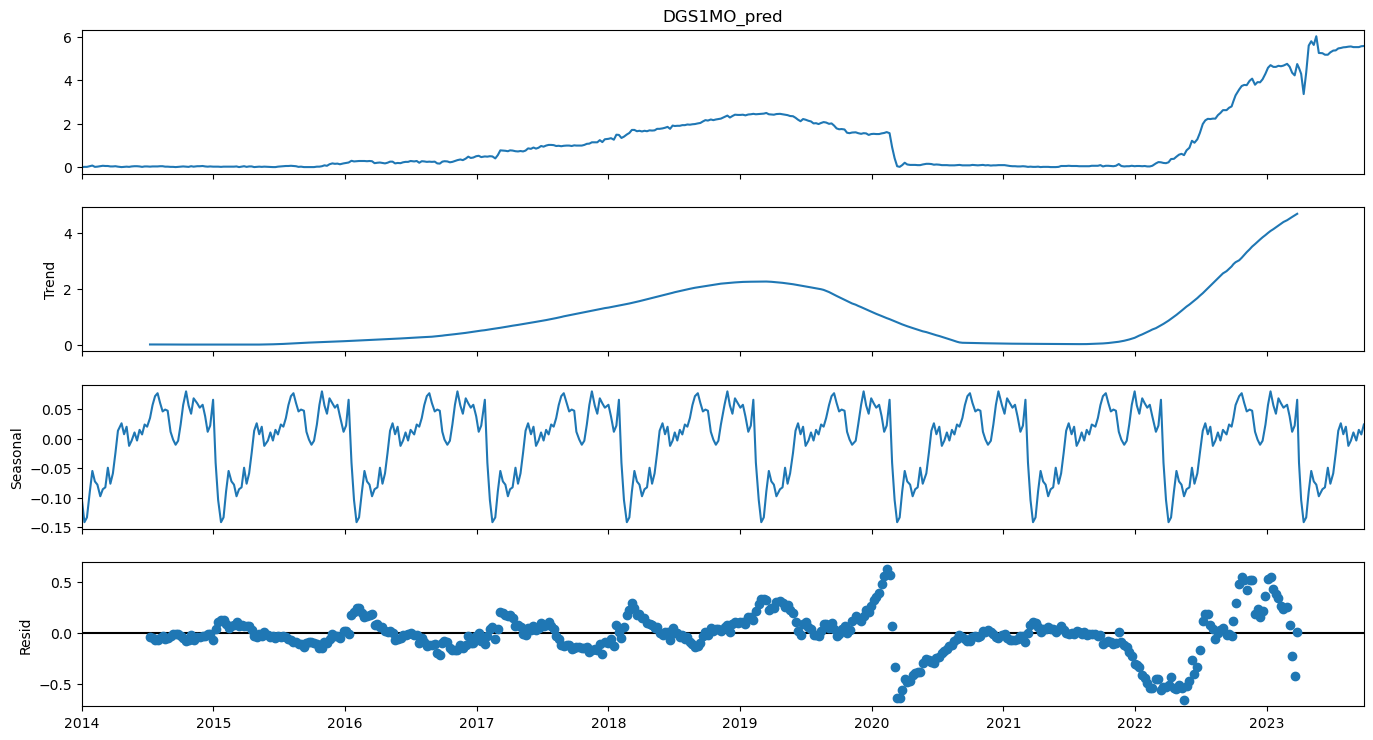

In [15]:
temp_Y = dataset['DGS1MO_pred']
res = sm.tsa.seasonal_decompose(temp_Y,period=52)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
pyplot.show()

#### 5 Year

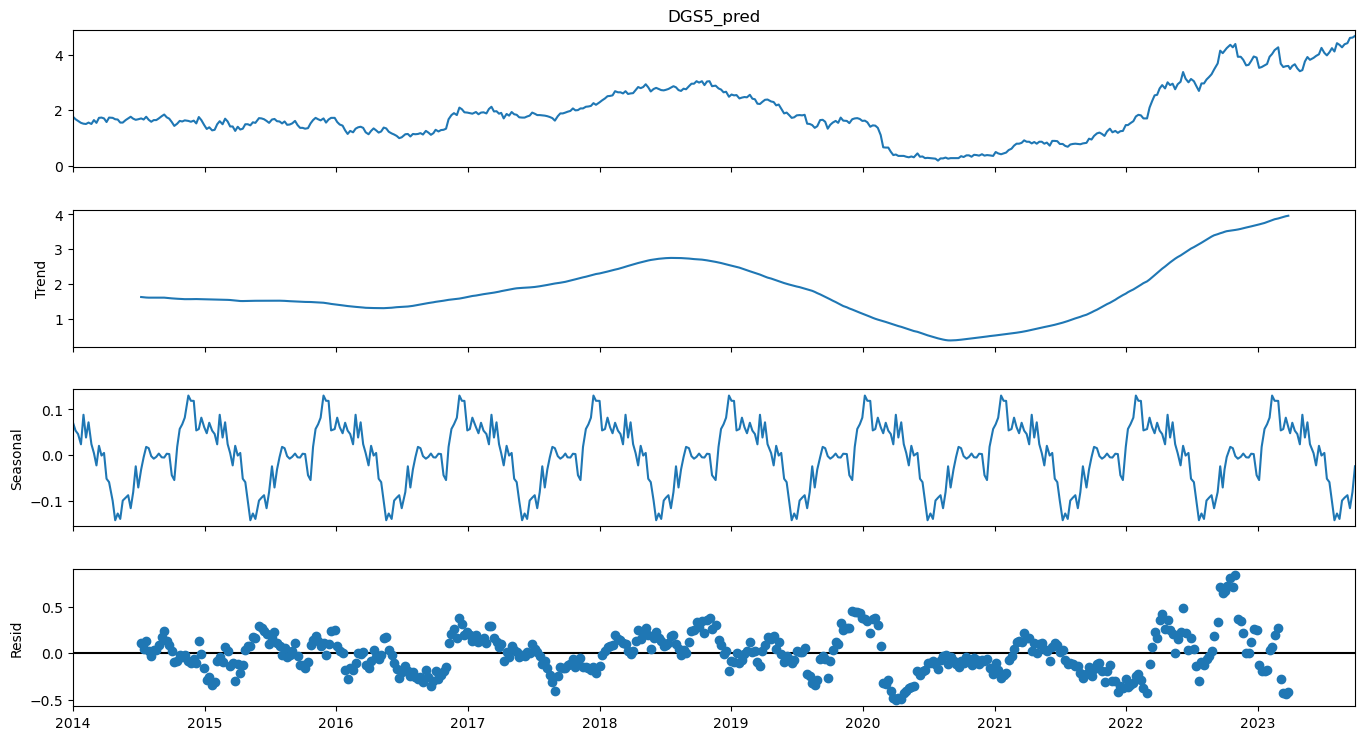

In [16]:
temp_Y = dataset['DGS5_pred']
res = sm.tsa.seasonal_decompose(temp_Y,period=52)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
pyplot.show()

#### 30 Year

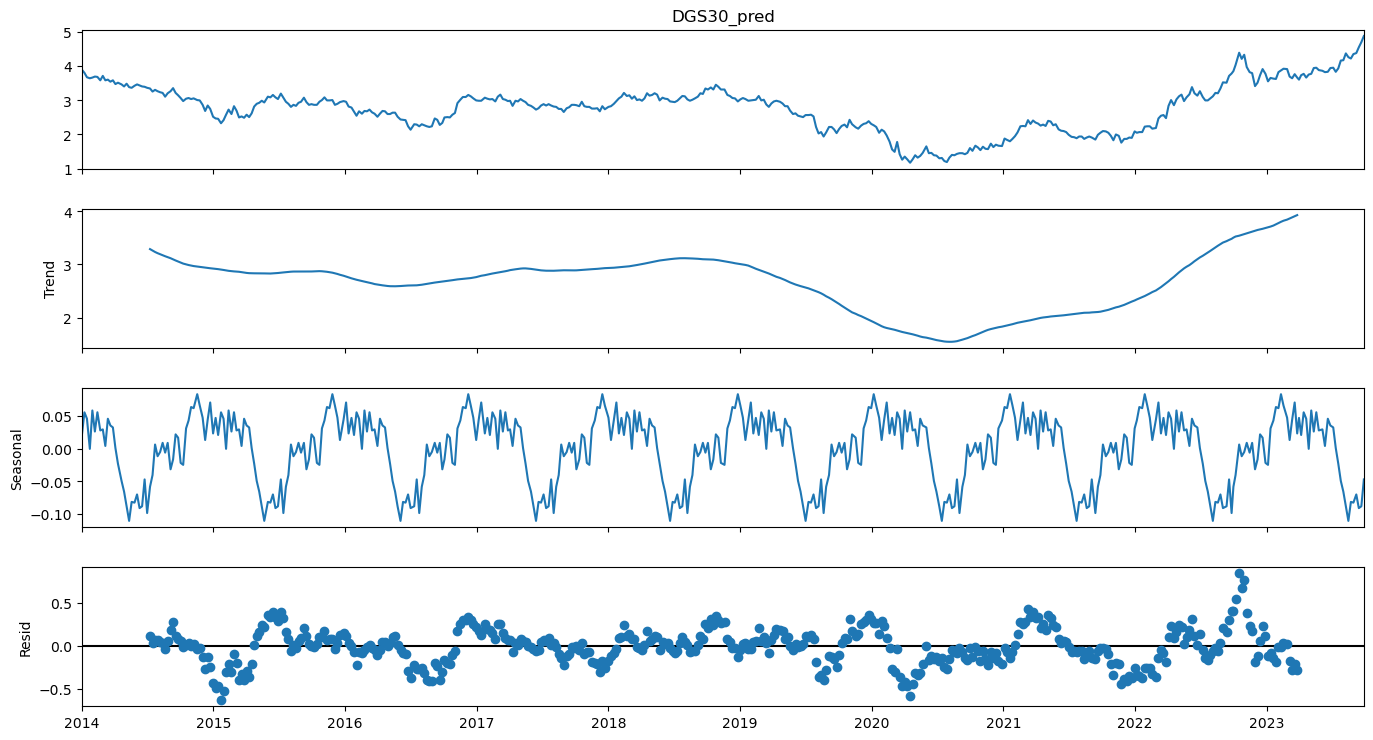

In [17]:
temp_Y = dataset['DGS30_pred']
res = sm.tsa.seasonal_decompose(temp_Y,period=52)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
pyplot.show()

Around Q1 2018, we observe a trend decrease in the 1 Month, 5 year and 30 year. However, the trend is most pronounced in the 1 month series.

<a id='3'></a>
## 4. Data Preparation and analysis

<a id='3.1'></a>
## 4.1. Univariate Feature Selection

In [18]:
bestfeatures = SelectKBest(k=5, score_func=f_regression)
for col in Y.columns:
    temp_Y = dataset[col]
    temp_X = dataset.loc[:, X.columns]
    fit = bestfeatures.fit(temp_X,temp_Y)
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(X.columns)
    #concat two dataframes for better visualization 
    featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    featureScores.columns = ['Specs','Score']  #naming the dataframe columns
    print(col)
    print(featureScores.nlargest(10,'Score'))  #print 10 best features
    print('--------------')

DGS1MO_pred
      Specs      Score
0    DGS1MO  72392.376
1    DGS3MO  47617.036
2      DGS1   8444.924
3      DGS2   3607.762
4      DGS5   1255.949
5      DGS7    846.176
6     DGS10    589.340
7     DGS30    283.845
10  FOR_PCT    229.054
11   BAA10Y     95.506
--------------
DGS5_pred
      Specs      Score
4      DGS5  40625.997
5      DGS7  13963.922
6     DGS10   4761.183
3      DGS2   4520.377
2      DGS1   2449.608
1    DGS3MO   1405.731
7     DGS30   1197.168
0    DGS1MO   1123.998
11   BAA10Y    126.770
10  FOR_PCT     91.577
--------------
DGS30_pred
      Specs      Score
7     DGS30  21701.655
6     DGS10   5006.197
5      DGS7   2405.195
4      DGS5   1283.864
3      DGS2    456.174
2      DGS1    362.973
1    DGS3MO    302.925
0    DGS1MO    277.421
11   BAA10Y     44.381
9   HOM_PCT     10.816
--------------


As expected, based on the univariate feature selection, all the time series are most dependent on the previous changes.

<a id='4'></a>
# 5. Evaluate Algorithms and Models

<a id='4.1'></a>
## 5.1. Train Test Split and evaluation metrics

In [19]:
# split out validation dataset for the end

validation_size = 0.2

#In case the data is not dependent on the time series, then train and test split randomly
seed = 7
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=seed)

We use the prebuilt scikit models to run a K fold analysis on our training data. We then train the model on the full training data and use it for prediction of the test data. The parameters for the K fold analysis are defined as -

In [20]:
# test options for regression
num_folds = 10
scoring = 'neg_mean_squared_error'

<a id='4.2'></a>
## 5.2. Compare Models and Algorithms

In [21]:
# spot check the algorithms
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
#Neural Network
models.append(('MLP', MLPRegressor()))

In [22]:
kfold_results = []
names = []
validation_results = []
train_results = []
for name, model in models:
    kfold = KFold(n_splits=num_folds)
    #converted mean square error to positive. The lower the beter
    cv_results = -1* cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)
    names.append(name)

    # Finally we Train on the full period and test against validation
    res = model.fit(X_train, Y_train)
    validation_result = np.mean(np.square(res.predict(X_validation) - Y_validation))
    validation_results.append(validation_result)
    train_result = np.mean(np.square(res.predict(X_train) - Y_train))
    train_results.append(train_result)
    
    msg = "%s: \nAverage CV error: %s \nStd CV Error: (%s) \nTraining Error:\n%s \nTest Error:\n%s" % \
    (name, str(cv_results.mean()), str(cv_results.std()), str(train_result), str(validation_result))
    print(msg)
    print('----------')

LR: 
Average CV error: 0.01162132137603433 
Std CV Error: (0.004799233858250829) 
Training Error:
DGS1MO_pred    0.008
DGS5_pred      0.012
DGS30_pred     0.010
dtype: float64 
Test Error:
DGS1MO_pred    0.029
DGS5_pred      0.011
DGS30_pred     0.011
dtype: float64
----------
LASSO: 
Average CV error: 0.5521548701860145 
Std CV Error: (0.17924713509705079) 
Training Error:
DGS1MO_pred    0.492
DGS5_pred      0.663
DGS30_pred     0.457
dtype: float64 
Test Error:
DGS1MO_pred    0.682
DGS5_pred      0.962
DGS30_pred     0.553
dtype: float64
----------
EN: 
Average CV error: 0.32486012272484954 
Std CV Error: (0.08858711782720353) 
Training Error:
DGS1MO_pred    0.210
DGS5_pred      0.322
DGS30_pred     0.418
dtype: float64 
Test Error:
DGS1MO_pred    0.270
DGS5_pred      0.429
DGS30_pred     0.485
dtype: float64
----------
KNN: 
Average CV error: 0.014787942564102563 
Std CV Error: (0.004727838595323095) 
Training Error:
DGS1MO_pred    0.008
DGS5_pred      0.010
DGS30_pred     0.008
dty

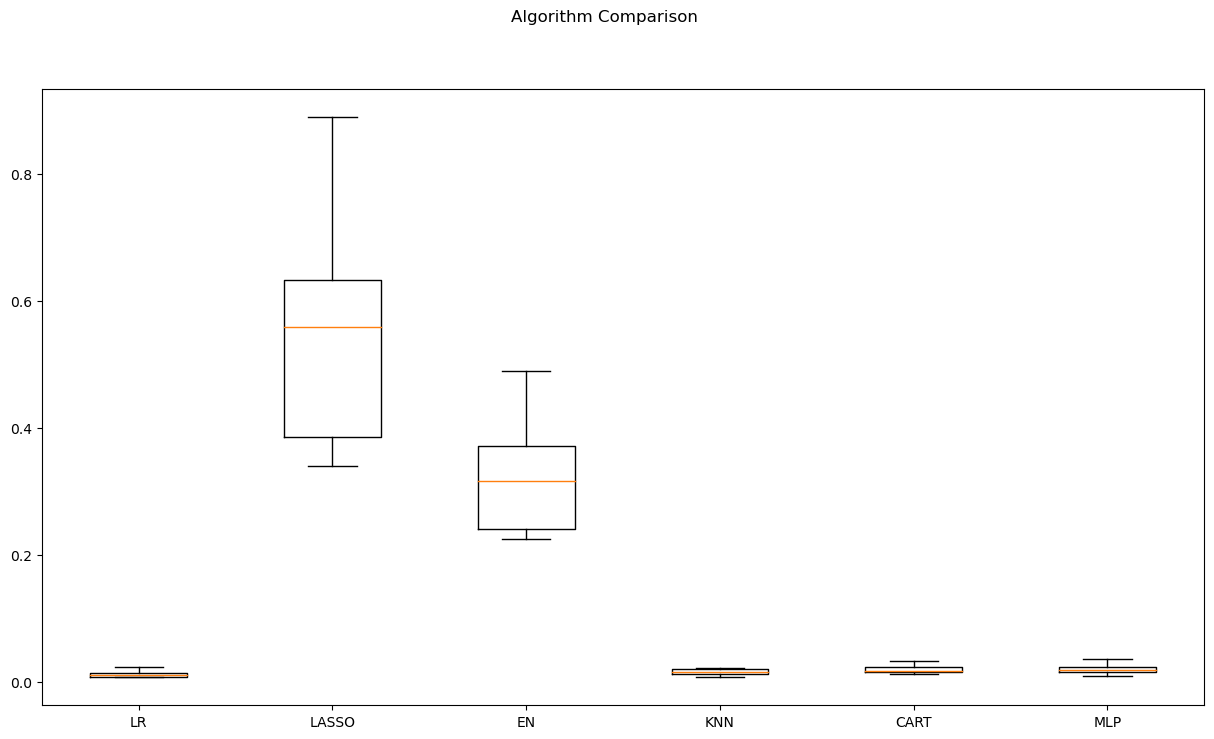

In [23]:
# compare algorithms
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
pyplot.show()

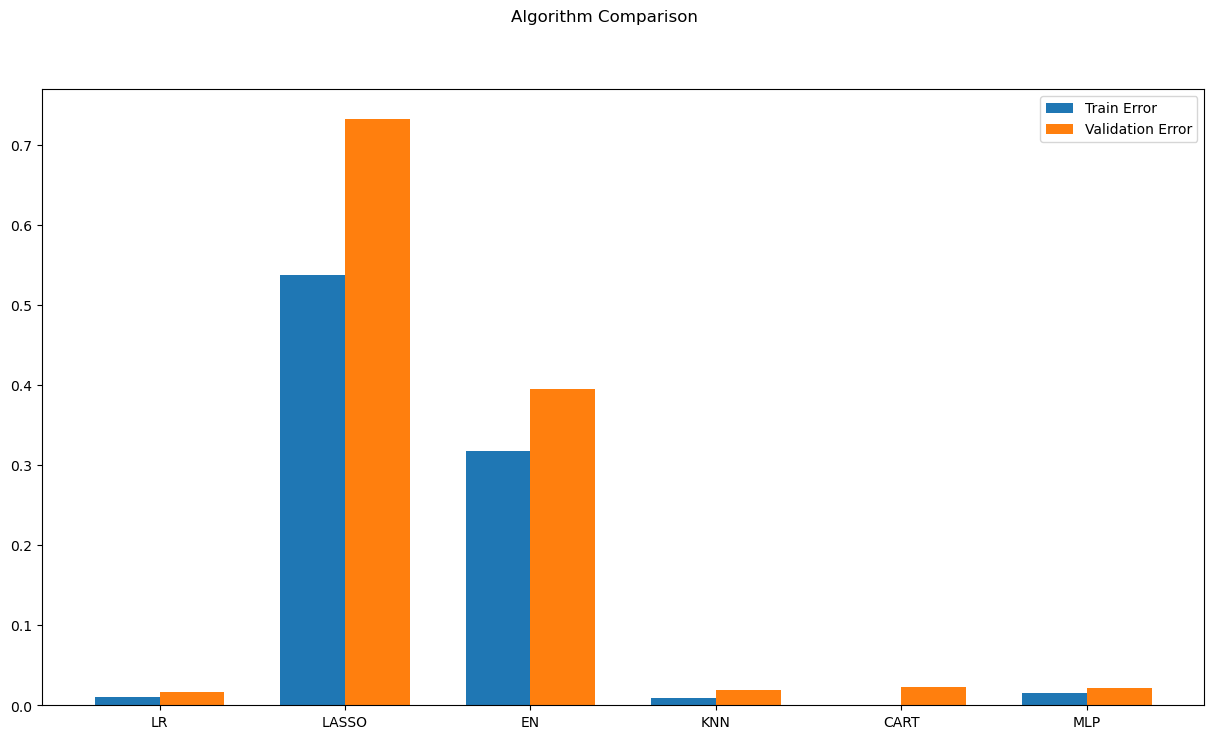

In [24]:
# compare algorithms
fig = pyplot.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, [x.mean() for x in train_results],  width=width, label='Train Error')
pyplot.bar(ind + width/2, [x.mean() for x in validation_results], width=width, label='Validation Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()

<a id='5'></a>
# 6. Model Tuning and Grid Search

In [25]:
# 7. Grid search : MLPRegressor 
'''
hidden_layer_sizes : tuple, length = n_layers - 2, default (100,)
    The ith element represents the number of neurons in the ith
    hidden layer.
'''
param_grid={'hidden_layer_sizes': [(20,), (50,), (20,20), (20, 30, 20)]}
model = MLPRegressor()
kfold = KFold(n_splits=num_folds)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.022808 using {'hidden_layer_sizes': (50,)}
-0.033096 (0.011401) with: {'hidden_layer_sizes': (20,)}
-0.022808 (0.007381) with: {'hidden_layer_sizes': (50,)}
-0.024719 (0.010073) with: {'hidden_layer_sizes': (20, 20)}
-0.023085 (0.007712) with: {'hidden_layer_sizes': (20, 30, 20)}


<a id='6'></a>
# 7. Finalise the Model

In [26]:
# prepare model
model = MLPRegressor(hidden_layer_sizes= (50,))
model.fit(X_train, Y_train)

MLPRegressor(hidden_layer_sizes=(50,))

<a id='6.1'></a>
## 7.1. Results and comparison of Regression and MLP

In [27]:
# estimate accuracy on validation set
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
predictions = model.predict(X_validation)
mse_MLP = mean_squared_error(Y_validation, predictions)
r2_MLP = r2_score(Y_validation, predictions)

# prepare model
model_2 = LinearRegression()
model_2.fit(X_train, Y_train)
predictions_2 = model_2.predict(X_validation)

mse_OLS = mean_squared_error(Y_validation, predictions_2)
r2_OLS = r2_score(Y_validation, predictions_2)
print("MSE Regression = %f, MSE MLP = %f" % (mse_OLS, mse_MLP ))
print("R2 Regression = %f, R2 MLP = %f" % (r2_OLS, r2_MLP ))


MSE Regression = 0.016808, MSE MLP = 0.020020
R2 Regression = 0.986969, R2 MLP = 0.983092


The statistics of MLP and Linear regression are comparable. Let us check the prediction shape on the validation set. 

### Predictions - 5 Year - MLP

In [28]:
train_size = int(len(X) * (1-validation_size))
X_train, X_validation = X[0:train_size], X[train_size:len(X)]
Y_train, Y_validation = Y[0:train_size], Y[train_size:len(X)]

modelMLP = MLPRegressor(hidden_layer_sizes= (50,))
modelOLS = LinearRegression()
model_MLP = modelMLP.fit(X_train, Y_train)
model_OLS = modelOLS.fit(X_train, Y_train)

Y_predMLP = pd.DataFrame(model_MLP.predict(X_validation), index=Y_validation.index,
                      columns=Y_validation.columns)

Y_predOLS = pd.DataFrame(model_OLS.predict(X_validation), index=Y_validation.index,
                      columns=Y_validation.columns)


<Axes: xlabel='DATE'>

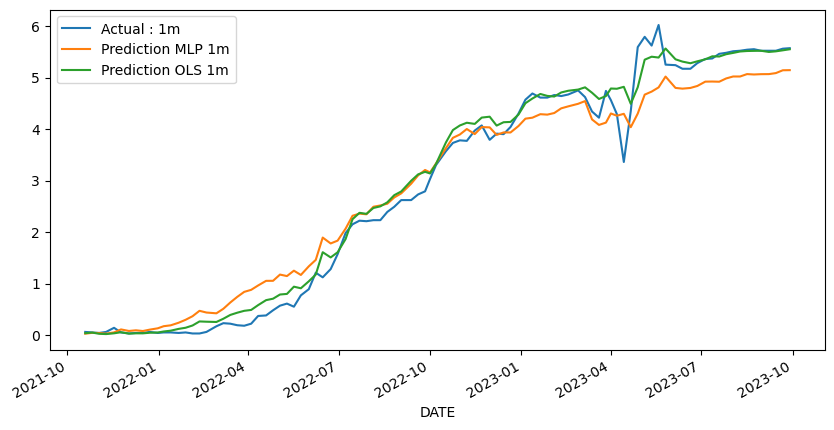

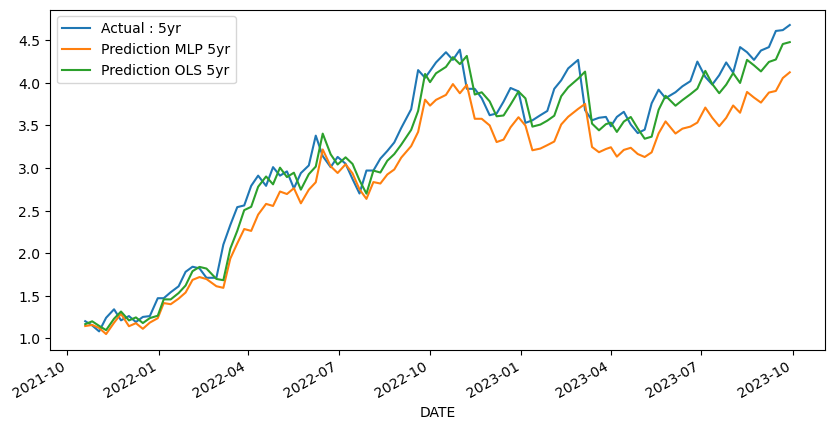

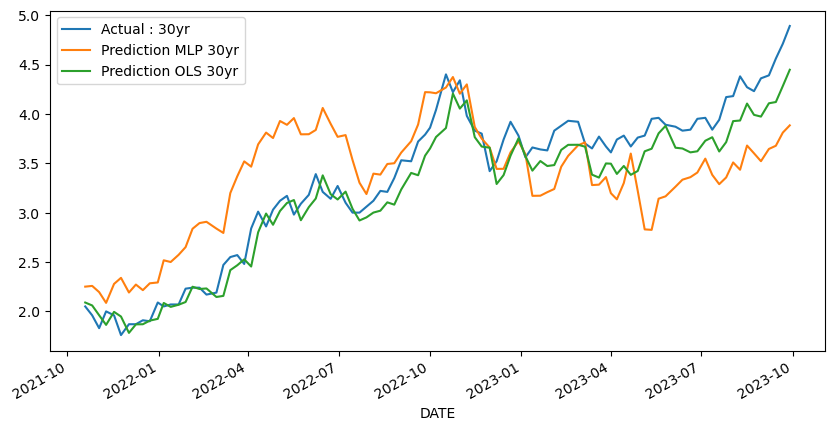

In [29]:
pd.DataFrame({'Actual : 1m': Y_validation.loc[:, 'DGS1MO_pred'],
              'Prediction MLP 1m': Y_predMLP.loc[:, 'DGS1MO_pred'],
              'Prediction OLS 1m': Y_predOLS.loc[:, 'DGS1MO_pred']}).plot(figsize=(10,5))

pd.DataFrame({'Actual : 5yr': Y_validation.loc[:, 'DGS5_pred'],
              'Prediction MLP 5yr': Y_predMLP.loc[:, 'DGS5_pred'],
              'Prediction OLS 5yr': Y_predOLS.loc[:, 'DGS5_pred']}).plot(figsize=(10,5))

pd.DataFrame({'Actual : 30yr': Y_validation.loc[:, 'DGS30_pred'],
              'Prediction MLP 30yr': Y_predMLP.loc[:, 'DGS30_pred'],
              'Prediction OLS 30yr': Y_predOLS.loc[:, 'DGS30_pred']}).plot(figsize=(10,5))



Overall, the regression and MLP are comparable, however, for 1m tenor, the fitting with MLP is slighly poor as compared to the regression. However,the multitask learning with neural network is more intuitive for modeling many time series simultaneousl 

### Summary

The linear regression model, despite its simplicity, is a tough benchmark to beat for such one step ahead forecasting, given the dominant characteristic of the last available value of the variable to predict. The ANN results in this case study are comparable to the linear regression models.

The good thing about ANN is that it is more flexible to changing market conditions. Also, ANN models can be enhanced by performing grid search on several other hyperparameters and using recurrent neural network such as LSTM.